### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 21 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 21 декабря, -4 балла после 08:30 28 декабря, -6 баллов после 08:30 04 янва, -8 баллов после 08:30 11 января.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Для того чтобы найти таргет, необходимо посчитать производные соответсвующих функций потерь, так как таргетом является: $$-\frac{\partial L}{\partial F}(F_{k-1}(x_i), y_i), \ 0 \leq i \leq N$$

Для MSE:
$$\frac{\partial L}{\partial a}(a(x_i), y_i) = 2 \cdot (a(x_i) - y_i)$$

Для экспоненциальной функции потерь:
$$\frac{\partial L}{\partial a}(a(x_i), y_i) = -y_i \cdot exp( -a(x_i) y_i)$$

Для логистической функции потерь:
$$\frac{\partial L}{\partial a}(a(x_i), y_i) = \frac{-y_i \cdot exp( -a(x_i) y_i)}{1 + exp( -a(x_i) y_i)}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [570]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [964]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=100, colsample=1, subsample=1, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        if loss == 'mse':
            self.loss = mse
        elif loss == 'exp':
            self.loss = exp
        elif loss == 'log':
            self.loss = log
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.ensemble = []
    
    def fit(self, X, y, base_model, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.features = np.zeros(self.n_estimators * int(self.colsample * X.shape[1]))
        self.features = self.features.reshape(self.n_estimators, -1).astype(int)
        model = base_model(*self.args, **self.kwargs)
        model.fit(X, y)
        self.ensemble.append(model)
        for i in range(1, self.n_estimators):
            model = base_model(*self.args, **self.kwargs)
            arg = np.random.choice(X.shape[0], int(self.subsample * X.shape[0]), replace=False)
            self.features[i] = np.random.choice(X.shape[1], int(self.colsample * X.shape[1]), replace=False)
            X_train = X[arg]
            pred = self.predict(X_train)
            y_train = -self.loss(pred, y[arg])
            model.fit(X_train[:, self.features[i]], y_train)
            self.ensemble.append(model)
        
    def predict(self, X):
        pred = np.zeros(X.shape[0])
        pred = self.ensemble[0].predict(X)
        for i in range(1, len(self.ensemble)):
            pred += self.learning_rate * self.ensemble[i].predict(X[:, self.features[i]])
        if self.loss == mse:
            pred = pred.astype(int)
        else:
            pred[pred < 0] = -1
            pred[pred >= 0] = 1
        return pred

    
def mse(a, y):
    return 2 * (a - y) 

def exp(a, y):
    return -y * np.exp(-a * y)

def log(a, y):
    return -y * np.exp(-a * y) / (1 + np.exp(-a * y))
    

Для объективности дефолтные параметры моей модели совпадают с дефолтными параметрами GradientBoostingClassifier

In [1089]:
my_clf = MyGradientBoostingClassifier(max_depth=3)
clf = GradientBoostingClassifier()

In [1090]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [1091]:
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8333333333333334
0.8888888888888888


Для того чтобы убедиться в качестве моей реализации проведу множество тестов

In [979]:
count = 20
score_myboost = np.zeros(count)
score = np.zeros(count)
score_sklearn = np.zeros(count)

for i in range(count):
    X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)
    my_clf = MyGradientBoostingClassifier(max_depth=3)
    my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
    score_myboost[i] = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    
    clf = DecisionTreeRegressor(max_depth=3)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test).astype(int)
    score[i] = accuracy_score(y_pred, y_test)
    
    clf = GradientBoostingClassifier()
    clf.fit(X_train, y_train)
    score_sklearn[i] = accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)
    
print("Скор одного DecisionTreeRegressor: ", score.mean())
print("Скор моей реализации градиентного бустинга: ", score_myboost.mean())
print("Скор sklearn реализации градиентного бустинга: ", score_sklearn.mean())

Скор одного DecisionTreeRegressor:  0.9222222222222222
Скор моей реализации градиентного бустинга:  0.9305555555555554
Скор sklearn реализации градиентного бустинга:  0.9361111111111109


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [991]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [992]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [811]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [996]:
n_estimators = np.arange(50, 500, 50)
scores = np.zeros(n_estimators.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

for i in tqdm(range(n_estimators.shape[0])):
    my_clf = MyGradientBoostingClassifier(loss='mse', n_estimators=n_estimators[i], learning_rate=0.1, max_depth=3)
    my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
    scores[i] = accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [09:22<00:00, 62.49s/it]


График зависимости точности от числа итераций:

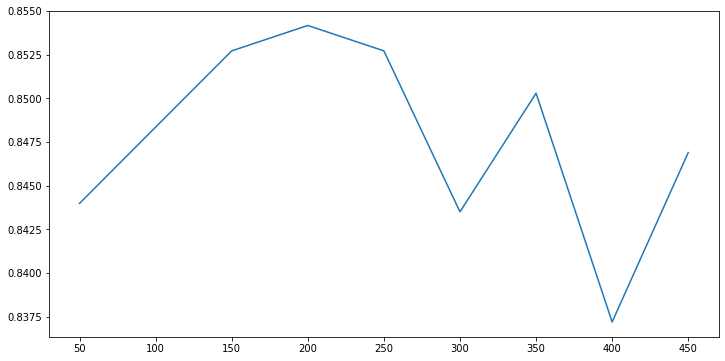

In [997]:
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, scores)
plt.show()

Возьму число итераций равное 100 и подберу для него наилучшую функцию потерь и значения парметров learning_rate и max_depth для DecisionTreeRegressor.

Для MSE:

In [ ]:
learning_rates = np.linspace(0.1, 1, 10)
scores_mse = np.zeros(learning_rates.shape[0])
count = 5

for i in range(learning_rates.shape[0]):
    for j in range(count):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
        my_clf = MyGradientBoostingClassifier(loss='mse', learning_rate=learning_rates[i], max_depth=3)
        my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
        scores_mse[i] += accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    scores_mse[i] /= count

In [983]:
y[y == 0] = -1

Для экспоненциальной функции потерь:

In [718]:
learning_rates = np.linspace(0.1, 1, 10)
scores_exp = np.zeros(learning_rates.shape[0])
count = 5

for i in range(learning_rates.shape[0]):
    for j in range(count):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
        my_clf = MyGradientBoostingClassifier(loss='exp', learning_rate=learning_rates[i], max_depth=3)
        my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
        scores_exp[i] += accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    scores_exp[i] /= count

Для логистической функции потерь:

In [716]:
learning_rates = np.linspace(0.1, 1, 10)
scores_log = np.zeros(learning_rates.shape[0])
count = 5

for i in range(learning_rates.shape[0]):
    for j in range(count):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
        my_clf = MyGradientBoostingClassifier(loss='log', learning_rate=learning_rates[i], max_depth=3)
        my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
        scores_log[i] += accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    scores_log[i] /= count

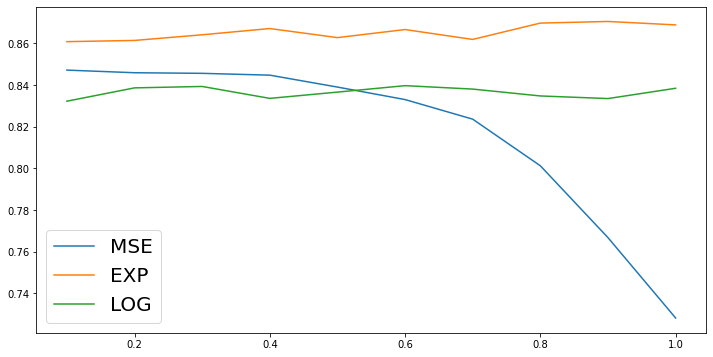

In [722]:
plt.figure(figsize=(12, 6))
plt.plot(learning_rates, scores_mse, label='MSE')
plt.plot(learning_rates, scores_exp, label='EXP')
plt.plot(learning_rates, scores_log, label='LOG')
plt.legend(fontsize=20)
plt.show()

Исходя из получившихся графиков, буду использовать экспоненциальную функцию потерь. А значение learning_rate возьму равным 0.8

In [806]:
depth = np.arange(3, 8)
scores = np.zeros(depth.shape[0])
count = 5

for i in range(depth.shape[0]):
    for j in range(count):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
        my_clf = MyGradientBoostingClassifier(loss='exp', learning_rate=0.8, max_depth=depth[i])
        my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
        scores[i] += accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)
    scores[i] /= count

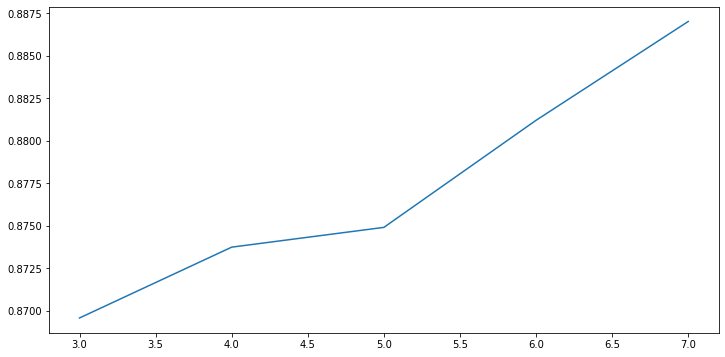

In [808]:
plt.figure(figsize=(12, 6))
plt.plot(depth, scores)
plt.show()

Значение max_depth возьму равным 7.

Осталось подобрать параметры subsample и colsample.

In [945]:
my_clf = MyGradientBoostingClassifier(loss='exp', learning_rate=0.8, max_depth=3)
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
pred = my_clf.predict(X_test)
print("SCORE = ", accuracy_score(pred, y_test), "SUBSAMPLE = ", s, "COLSAMPLE = ", c)

SCORE =  0.6506782945736435 SUBSAMPLE =  0.8 COLSAMPLE =  0.8


In [985]:
subsample = [0.7, 0.8, 0.9, 1]
colsample = [0.7, 0.8, 0.9, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

for c in colsample:
    for s in subsample:
        my_clf = MyGradientBoostingClassifier(loss='exp', subsample=s, colsample=c, learning_rate=0.8, max_depth=7)
        my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
        pred = my_clf.predict(X_test)
        print("SCORE = ", accuracy_score(pred, y_test), "SUBSAMPLE = ", s, "COLSAMPLE = ", c)

SCORE =  0.8798449612403101 SUBSAMPLE =  0.7 COLSAMPLE =  0.7
SCORE =  0.8808139534883721 SUBSAMPLE =  0.8 COLSAMPLE =  0.7
SCORE =  0.8783914728682171 SUBSAMPLE =  0.9 COLSAMPLE =  0.7
SCORE =  0.8798449612403101 SUBSAMPLE =  1 COLSAMPLE =  0.7
SCORE =  0.8788759689922481 SUBSAMPLE =  0.7 COLSAMPLE =  0.8
SCORE =  0.877906976744186 SUBSAMPLE =  0.8 COLSAMPLE =  0.8
SCORE =  0.8803294573643411 SUBSAMPLE =  0.9 COLSAMPLE =  0.8
SCORE =  0.8827519379844961 SUBSAMPLE =  1 COLSAMPLE =  0.8
SCORE =  0.8812984496124031 SUBSAMPLE =  0.7 COLSAMPLE =  0.9
SCORE =  0.8832364341085271 SUBSAMPLE =  0.8 COLSAMPLE =  0.9
SCORE =  0.8817829457364341 SUBSAMPLE =  0.9 COLSAMPLE =  0.9
SCORE =  0.8783914728682171 SUBSAMPLE =  1 COLSAMPLE =  0.9
SCORE =  0.8832364341085271 SUBSAMPLE =  0.7 COLSAMPLE =  1
SCORE =  0.8808139534883721 SUBSAMPLE =  0.8 COLSAMPLE =  1
SCORE =  0.873062015503876 SUBSAMPLE =  0.9 COLSAMPLE =  1
SCORE =  0.8788759689922481 SUBSAMPLE =  1 COLSAMPLE =  1


Итоговая лучшая модель:

In [987]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf = MyGradientBoostingClassifier(loss='exp', n_estimators=400, learning_rate=0.8, max_depth=7, \
                                      subsample=0.8, colsample=0.9)
my_clf.fit(X_train, y_train, base_model=DecisionTreeRegressor)
pred = my_clf.predict(X_test)
accuracy_score(pred, y_test)

0.8919573643410853

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

1)

In [1001]:
from sklearn.ensemble import RandomForestRegressor

In [1068]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf = MyGradientBoostingClassifier(loss='exp', n_estimators=50, learning_rate=0.8, max_depth=3)
my_clf.fit(X_train, y_train, base_model=RandomForestRegressor)
pred = my_clf.predict(X_test)
accuracy_score(pred, y_test)

0.8788759689922481

Качество не улучшилось. Тот факт, что теперь вместо одного дерева решений используется Random Forest не улучшает модель, потому что хотя на каждой итерации в отдельности скор может быть лучше, итогового прироста качества это не вызовет, так как мы для того и делаем бустинг, чтобы нивелировать ошибки предыдущих моделей. При этом время работы возрастает и приходится уменьшать число шагов бустинга для приемлемого времени работы.

2)

In [1066]:
subsample = 0.7
colsample = 0.7
n_trees = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
pred = np.zeros(y_test.shape[0])
for i in range(n_trees):
    arg = np.random.choice(X_train.shape[0], int(subsample * X_train.shape[0]), replace=False)
    features = np.random.choice(X_train.shape[1], int(colsample * X_train.shape[1]), replace=False)
    my_clf = MyGradientBoostingClassifier(loss='exp', n_estimators=100, learning_rate=0.8, max_depth=7)
    my_clf.fit(X_train[arg][:, features], y_train[arg], base_model=DecisionTreeRegressor)
    pred_p = my_clf.predict(X_test[:, features])
    pred += pred_p
    
pred = (pred / n_trees)
pred[pred < 0] = -1
pred[pred >= 0] = 1
accuracy_score(pred, y_test)

0.8968023255813954

А вот такая стратегия позволила увеличить скор. Работает та же идея что и в Random Forest, много моделей голосованием дают итоговое предсказание лучше чем каждая из моделей в отдельности.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

